<a href="https://colab.research.google.com/github/astridjerald/colorizer/blob/master/Pix2Pix_colorizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pix2Pix in Tensorflow

In [22]:
#Import the libraries we will need.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
import os
import scipy.misc
import scipy
from PIL import Image
from glob import glob
import os
%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive')
#Size of image frames
height = 144
width = 256

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.misc
import os
import csv
import itertools
import tensorflow.contrib.slim as slim
from PIL import Image


#Generates gifs
def make_gif(images, fname, duration=2, true_image=False):
  import moviepy.editor as mpy
  
  def make_frame(t):
    try:
      x = images[int(len(images)/duration*t)]
    except:
      x = images[-1]

    if true_image:
      return x.astype(np.uint8)
    else:
      return ((x+1)/2*255).astype(np.uint8)
  
  clip = mpy.VideoClip(make_frame, duration=duration)
  clip.write_gif(fname, fps = len(images) / duration,verbose=False)

#Function loads images from list of files. bw_bool is True when the source images are originally greyscale and 4:3
#Flip determines whether images should be flipped 
def loadImages(data,bw_bool,flip):
    images = []
    images_bw = []
    if bw_bool == False:
        for myFile in data:
            img = Image.open(myFile)
            bw = np.max(img,2)
            bw = np.stack([bw,bw,bw],2)
            bw[:,:40,:] = 0
            bw[:,-40:,:] = 0
            if flip == False:
                images.append(np.array(img))
                images_bw.append(bw)
            else:
                img_flip = np.fliplr(img)
                images.append(img_flip)
                bw_flip = np.fliplr(bw)
                images_bw.append(bw_flip)
        images = np.array(images)
        images = images.astype('float32')
        images = images / 256
        images_bw = np.array(images_bw)
        images_bw = images_bw.astype('float32')
        images_bw = images_bw / 256
        return images,images_bw
    else:
        for myFile in data:
            img = Image.open(myFile)
            bw = img.resize((196,144))
            bw = np.max(bw,2)
            bw = np.stack([bw,bw,bw],2)
            bw_w = np.zeros([144,256,3])
            bw_w[:,30:-30,:] = bw
            bw_w[:,:40,:] = 0
            bw_w[:,-40:,:] = 0
        images.append(bw_w)
        images = np.array(images)
        images = images.astype('float32')
        images = images / 256
        return images

#This function performns a leaky relu activation, which is needed for the discriminator network.
def lrelu(x, leak=0.2, name="lrelu"):
     with tf.variable_scope(name):
         f1 = 0.5 * (1 + leak)
         f2 = 0.5 * (1 - leak)
         return f1 * x + f2 * abs(x)
    
#The below functions are taken from carpdem20's implementation https://github.com/carpedm20/DCGAN-tensorflow
#They allow for saving sample images from the generator to follow progress
def save_images(images, size, image_path):
    return imsave(inverse_transform(images), size, image_path)

def imsave(images, size, path):
    return scipy.misc.imsave(path, merge(images, size))

def inverse_transform(images):
    return (images+1.)/2.

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1],3))

    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx / size[1]
        img[j*h:j*h+h, i*w:i*w+w,:] = image

    return img

[array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.0078125 ],
         [0.        , 0.        , 0.0078125 

TypeError: ignored

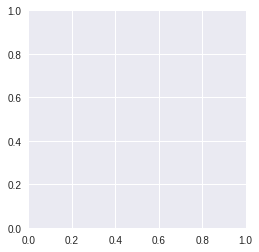

In [32]:
data=loadImages(['/content/gdrive/My Drive/pix2pix_images/out0001.png'],False,False)

from matplotlib import pyplot as plt
print(list(data))
plt.imshow(data[0], interpolation='nearest')
plt.show()

## Defining the Adversarial Networks

### Generator Network

In [0]:
def generator(c):
    with tf.variable_scope('generator'):
        #Encoder
        enc0 = slim.conv2d(c,64,[3,3],padding="SAME",
            biases_initializer=None,activation_fn=lrelu,
            weights_initializer=initializer)
        enc0 = tf.space_to_depth(enc0,2)
        
        enc1 = slim.conv2d(enc0,128,[3,3],padding="SAME",
            activation_fn=lrelu,normalizer_fn=slim.batch_norm,
            weights_initializer=initializer)
        enc1 = tf.space_to_depth(enc1,2)

        enc2 = slim.conv2d(enc1,128,[3,3],padding="SAME",
            normalizer_fn=slim.batch_norm,activation_fn=lrelu,
            weights_initializer=initializer)
        enc2 = tf.space_to_depth(enc2,2)

        enc3 = slim.conv2d(enc2,256,[3,3],padding="SAME",
            normalizer_fn=slim.batch_norm,activation_fn=lrelu,
            weights_initializer=initializer)
        enc3 = tf.space_to_depth(enc3,2)
        
        #Decoder
        gen0 = slim.conv2d(
            enc3,num_outputs=256,kernel_size=[3,3],
            padding="SAME",normalizer_fn=slim.batch_norm,
            activation_fn=tf.nn.elu, weights_initializer=initializer)
        gen0 = tf.depth_to_space(gen0,2)

        gen1 = slim.conv2d(
            tf.concat([gen0,enc2],3),num_outputs=256,kernel_size=[3,3],
            padding="SAME",normalizer_fn=slim.batch_norm,
            activation_fn=tf.nn.elu,weights_initializer=initializer)
        gen1 = tf.depth_to_space(gen1,2)

        gen2 = slim.conv2d(
            tf.concat([gen1,enc1],3),num_outputs=128,kernel_size=[3,3],
            padding="SAME",normalizer_fn=slim.batch_norm,
            activation_fn=tf.nn.elu,weights_initializer=initializer)
        gen2 = tf.depth_to_space(gen2,2)

        gen3 = slim.conv2d(
            tf.concat([gen2,enc0],3),num_outputs=128,kernel_size=[3,3],
            padding="SAME",normalizer_fn=slim.batch_norm,
            activation_fn=tf.nn.elu, weights_initializer=initializer)
        gen3 = tf.depth_to_space(gen3,2)
        
        g_out = slim.conv2d(
            gen3,num_outputs=3,kernel_size=[1,1],padding="SAME",
            biases_initializer=None,activation_fn=tf.nn.tanh,
            weights_initializer=initializer)
        return g_out

### Discriminator Network

In [0]:
def discriminator(bottom, reuse=False):
    with tf.variable_scope('discriminator'):
        filters = [32,64,128,128]
        
        #Programatically define layers
        for i in range(len(filters)):
            if i == 0:
                layer = slim.conv2d(bottom,filters[i],[3,3],padding="SAME",scope='d'+str(i),
                    biases_initializer=None,activation_fn=lrelu,stride=[2,2],
                    reuse=reuse,weights_initializer=initializer)
            else:
                layer = slim.conv2d(bottom,filters[i],[3,3],padding="SAME",scope='d'+str(i),
                    normalizer_fn=slim.batch_norm,activation_fn=lrelu,stride=[2,2],
                    reuse=reuse,weights_initializer=initializer)
            bottom = layer

        dis_full = slim.fully_connected(slim.flatten(bottom),1024,activation_fn=lrelu,scope='dl',
            reuse=reuse, weights_initializer=initializer)

        d_out = slim.fully_connected(dis_full,1,activation_fn=tf.nn.sigmoid,scope='do',
            reuse=reuse, weights_initializer=initializer)
        return d_out

### Connecting them together

In [0]:
tf.reset_default_graph()

#This initializaer is used to initialize all the weights of the network.
initializer = tf.truncated_normal_initializer(stddev=0.02)

#
condition_in = tf.placeholder(shape=[None,height,width,3],dtype=tf.float32)
real_in = tf.placeholder(shape=[None,height,width,3],dtype=tf.float32) #Real images

Gx = generator(condition_in) #Generates images from random z vectors
Dx = discriminator(real_in) #Produces probabilities for real images
Dg = discriminator(Gx,reuse=True) #Produces probabilities for generator images

#These functions together define the optimization objective of the GAN.
d_loss = -tf.reduce_mean(tf.log(Dx) + tf.log(1.-Dg)) #This optimizes the discriminator.
#For generator we use traditional GAN objective as well as L1 loss
g_loss = -tf.reduce_mean(tf.log(Dg)) + 100*tf.reduce_mean(tf.abs(Gx - real_in)) #This optimizes the generator.

#The below code is responsible for applying gradient descent to update the GAN.
trainerD = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
trainerG = tf.train.AdamOptimizer(learning_rate=0.002,beta1=0.5)
d_grads = trainerD.compute_gradients(d_loss,slim.get_variables(scope='discriminator'))
g_grads = trainerG.compute_gradients(g_loss, slim.get_variables(scope='generator'))

update_D = trainerD.apply_gradients(d_grads)
update_G = trainerG.apply_gradients(g_grads)

## Training the network


In [0]:
batch_size = 4 #Size of image batch to apply at each iteration.
iterations = 500000 #Total number of iterations to use.
subset_size = 5000 #How many images to load at a time, will vary depending on available resources
frame_directory = './frames' #Directory where training images are located
sample_directory = './samples' #Directory to save sample images from generator in.
model_directory = './model' #Directory to save trained model to.
sample_frequency = 200 #How often to generate sample gif of translated images.
save_frequency = 5000 #How often to save model.
load_model = False #Whether to load the model or begin training from scratch.

In [0]:
subset = 0
dataS = sorted(glob(os.path.join(frame_directory, "*.png")))
total_subsets = len(dataS)/subset_size
init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    if load_model == True: 
        ckpt = tf.train.get_checkpoint_state(model_directory)
        saver.restore(sess,ckpt.model_checkpoint_path)

    imagesY,imagesX = loadImages(dataS[0:subset_size],False, np.random.randint(0,2)) #Load a subset of images
    print "Loaded subset " + str(subset)
    draw = range(len(imagesX))
    for i in range(iterations):
        if i % (subset_size/batch_size) != 0 or i == 0:
            batch_index = np.random.choice(draw,size=batch_size,replace=False)
        else:
            subset = np.random.randint(0,total_subsets+1)
            imagesY,imagesX = loadImages(dataS[subset*subset_size:(subset+1)*subset_size],False, np.random.randint(0,2))
            print "Loaded subset " + str(subset)
            draw = range(len(imagesX))
            batch_index = np.random.choice(draw,size=batch_size,replace=False)
        
        ys = (np.reshape(imagesY[batch_index],[batch_size,height,width,3]) - 0.5) * 2.0 #Transform to be between -1 and 1
        xs = (np.reshape(imagesX[batch_index],[batch_size,height,width,3]) - 0.5) * 2.0
        _,dLoss = sess.run([update_D,d_loss],feed_dict={real_in:ys,condition_in:xs}) #Update the discriminator
        _,gLoss = sess.run([update_G,g_loss],feed_dict={real_in:ys,condition_in:xs}) #Update the generator
        if i % sample_frequency == 0:
            print "Gen Loss: " + str(gLoss) + " Disc Loss: " + str(dLoss)
            start_point = np.random.randint(0,len(imagesX)-32)
            xs = (np.reshape(imagesX[start_point:start_point+32],[32,height,width,3]) - 0.5) * 2.0
            ys = (np.reshape(imagesY[start_point:start_point+32],[32,height,width,3]) - 0.5) * 2.0
            sample_G = sess.run(Gx,feed_dict={condition_in:xs}) #Use new z to get sample images from generator.
            allS = np.concatenate([xs,sample_G,ys],axis=1)
            if not os.path.exists(sample_directory):
                os.makedirs(sample_directory)
            #Save sample generator images for viewing training progress.
            make_gif(allS,'./'+sample_directory+'/a_vid'+str(i)+'.gif',
                duration=len(allS)*0.2,true_image=False)
        if i % save_frequency == 0 and i != 0:
            if not os.path.exists(model_directory):
                os.makedirs(model_directory)
            saver.save(sess,model_directory+'/model-'+str(i)+'.cptk')
            print "Saved Model"

## Using a trained network

In [0]:
test_directory = '/content/gdrive/My Drive/pix2pix_images' #Directory to load test frames from
subset_size = 5000
batch_size = 60 # Size of image batch to apply at each iteration. Will depend of available resources.
sample_directory = '/content/gdrive/My Drive/firegan' #Directory to save sample images from generator in.
model_directory = '/content/gdrive/My Drive/model' #Directory to save trained model to.
load_model = True #Whether to load a saved model.

In [19]:
print(sorted(glob(os.path.join(test_directory, "*.png"))))

['/content/gdrive/My Drive/pix2pix_images/out0001.png', '/content/gdrive/My Drive/pix2pix_images/out0002.png', '/content/gdrive/My Drive/pix2pix_images/out0003.png', '/content/gdrive/My Drive/pix2pix_images/out0004.png', '/content/gdrive/My Drive/pix2pix_images/out0005.png', '/content/gdrive/My Drive/pix2pix_images/out0006.png', '/content/gdrive/My Drive/pix2pix_images/out0007.png', '/content/gdrive/My Drive/pix2pix_images/out0008.png', '/content/gdrive/My Drive/pix2pix_images/out0009.png', '/content/gdrive/My Drive/pix2pix_images/out0010.png', '/content/gdrive/My Drive/pix2pix_images/out0011.png']


In [21]:
dataS = sorted(glob(os.path.join(test_directory, "*.png")))
subset = 0
total_subsets = len(dataS)/subset_size
iterations = subset_size / batch_size #Total number of iterations to use.


if not os.path.exists(sample_directory):
    os.makedirs(sample_directory)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    if load_model == True: 
        ckpt = tf.train.get_checkpoint_state(model_directory)
        saver.restore(sess,ckpt.model_checkpoint_path)
        for s in range(total_subsets):
            generated_frames = []
            _,imagesX = loadImages(dataS[s*subset_size:s*subset_size+subset_size],False, False) #Load a subset of images
            for i in range(iterations):
                start_point = i * batch_size
                xs = (np.reshape(imagesX[start_point:start_point+batch_size],[batch_size,height,width,3]) - 0.5) * 2.0
                sample_G = sess.run(Gx,feed_dict={condition_in:xs}) #Use new z to get sample images from generator.    
                #allS = np.concatenate([xs,sample_G],axis=2)
                generated_frames.append(sample_G)
            generated_frames = np.vstack(generated_frames)
            for i in range(len(generated_frames)):
                im = Image.fromarray(((generated_frames[i]/2.0 + 0.5) * 256).astype('uint8'))
                im.save('./'+sample_directory+'/frame'+str(s*subset_size + i)+'.png')  
            #make_gif(generated_frames,'./'+sample_directory+'/a_vid'+str(i)+'.gif',
            #    duration=len(generated_frames)/10.0,true_image=False)

ValueError: ignored